In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import operator
import nltk
import math
from scipy.stats import norm
from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn
import random
import spacy
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from google.colab import files

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import os

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
adjudications = files.upload()

Saving adjudications.csv to adjudications.csv


In [ ]:
adjudications = pd.read_csv("adjudications.csv") # has 544 data points
adjudications = adjudications.sample(frac=1, random_state=11).drop(columns=['data point ID', 'adjudicated'])
training = adjudications[:327] # training with 327 rows has around 60% of the 544 data points
development = adjudications[327:436] # development with 109 rows has around 20% of the 544 data points
test = adjudications[436:544] # test with 108 rows has around 20% of the 544 data points
training

,label,text
369,witty,"We’re renovating the house, and the first floo..."
372,funny,Why do peppers make such good archers? Because...
175,funny,My wife gave me an ultimatum: Her or my addict...
538,lame,What did the ravioli play on his birthday? Pas...
347,lame,If Trump wanted to avoid impeachment... ...he ...
...,...,...
479,witty,Do you know how many people are dead at a ceme...
384,funny,"My mother in law bought a talking parrot, but ..."
478,lame,"Denmark: ""We will kill 17 million minks by 202..."
289,witty,Where do you learn all about ice cream? Sundae...


In [ ]:
# make txt files
training.to_csv("train.tsv", sep="\t", index=False)
os.rename("train.tsv", "train.txt")

development.to_csv("dev.tsv", sep="\t", index=False)
os.rename("dev.tsv", "dev.txt")

test.to_csv("test.tsv", sep="\t", index=False)
os.rename("test.tsv", "test.txt")

In [ ]:
trainX = training['text']
trainY = training['label']
devX = development['text']
devY = development['label']
testX = test['text']
testY = test['label']

# Logistic Regression Model

In [ ]:
#Logistic Regression

class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model


    def test(self):
        return self.log_reg.score(self.testX, self.testY)


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
simple_classifier.train()
accuracy=simple_classifier.test()
accuracy

0.5

In [ ]:
confidence_intervals(accuracy, len(testX), 0.95)

(0.43362460192128294, 0.6219309536342726)

# Majority Class Classifier

In [ ]:
#Majority Class Classifier
def majority_class(trainY, evalY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]

    correct=0.
    for label in evalY:
        if label == majority_class:
            correct+=1
    return majority_class, correct/len(evalY)

mc, mc_devAcc=majority_class(trainY, devY)
_, mc_testAcc=majority_class(trainY, testY)

print("Majority class: %s, dev accuracy: %.3f, test accuracy: %.3f" % (mc, mc_devAcc, mc_testAcc))

Majority class: witty, dev accuracy: 0.743, test accuracy: 0.574


In [ ]:
confidence_intervals(mc_testAcc, len(testX), 0.95)

(0.4808158333587301, 0.667332314789418)

# Featurizations For Main Model

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# featurizations

def multiple_meanings(text):
    '''
    one possible feature for pun detection.
    this function looks for multiple meanings in the words in a given text.
    '''

    features = {}
    tokens = nltk.word_tokenize(text)

    for token in tokens:
      token = token.lower()
      synsets = wordnet.synsets(token)
      if token not in features.keys():
          features[token] = len(synsets)

    return features

def culture_references(text):
    '''
    a possible feature to detect whether a joke makes general and/or pop culture references.
    primarily utilizes named entity recognition (NER).
    '''
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    named_entities = [ent.text for ent in doc.ents]

    features = {}
    tokens = nltk.word_tokenize(text)

    for token in tokens:
        if token in named_entities:
            features[token] = 1
        else:
            features[token] = 0

    return features

def expected_pos(text): # food for thought
    # detects whether a word in a text is the expected part of speech
    # if not, this may be indicative of the word's purpose as a pun
    tokens = nltk.word_tokenize(text)
    pos_tags = pos_tag(tokens)

def word_count(text):
    '''
    classifies as 'witty' or not-'witty' based on word count.
    Based on EDA, we find that the avg word count for 'witty' label is ~14.7, while 'funny' is ~18.9 and 'lame' is ~19.8.
    '''
    witty_count = 14.7
    funny_count = 18.9
    lame_count = 19.8

    features = {}
    tokens = nltk.word_tokenize(text)
    len_joke = len(tokens)

    witty_diff = abs(witty_count - len_joke)
    funny_diff = abs(funny_count - len_joke)
    lame_diff = abs(lame_count - len_joke)
    differences = {witty_diff: "witty", funny_diff: "funny", lame_diff: "lame"}

    min_diff = min(witty_diff, funny_diff, lame_diff)

    features[differences[min_diff]] = min_diff
    return features

def word_identifiers(text):
    '''
    classifies as 'lame' if topic of joke contains a word from a list of words
    Utilizes BoW
    '''
    lame_words = ['onlyfans', 'trump', 'dick', 'nut', 'corona', 'covid', 'covid-19', 'date', 'sex', "drunk", "women"]
    funny_words = ["said", "dad", "told", "but", "replies", "replied"]
    witty_words = []

    not_lame_words = []
    not_funny_words = ["why"]
    not_witty_words = []

    features = {"lame": 0, "funny": 0, "witty": 0}
    tokens = nltk.word_tokenize(text)

    for token in tokens:
        token = token.lower()
        if token in lame_words:
            features["lame"] += 1
        if token in funny_words:
            features["funny"] += 1
        if token in witty_words:
            features["witty"] = 1
        if token in not_lame_words:
            features["lame"] -= 1
        if token in not_funny_words:
            features["funny"] -= 1
        if token in not_witty_words:
            features["witty"] -= 1

    return features

In [ ]:
# consolidate all features into one function to feed into our classifier later
def combined_features(text):
    all_features={}
    for feature in [multiple_meanings, culture_references, word_count, word_identifiers, binary_bow_featurize]:
        all_features.update(feature(text))
    return all_features

# Classifier with features

In [ ]:
features_classifier = Classifier(combined_features, trainX, trainY, devX, devY, testX, testY)
features_classifier.train()
feature_accuracy=features_classifier.test()
feature_accuracy

0.5277777777777778

**Model Accuracy: 0.52778**

In [ ]:
confidence_intervals(feature_accuracy, len(testX), 0.95)

(0.43362460192128294, 0.6219309536342726)

**95% Confidence Interval: (0.4336, 0.6219)**

#Analysis

In [ ]:
predictions = features_classifier.log_reg.predict(features_classifier.testX)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as plt
import seaborn as sns

[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(50.722222222222214, 0.5, 'Truth')]

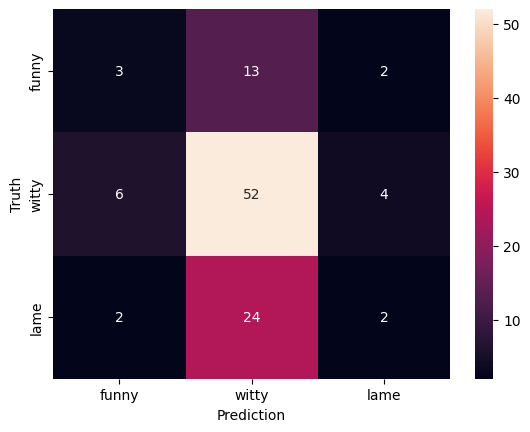

In [ ]:
confusion = confusion_matrix(testY, predictions, labels=['funny', 'witty', 'lame'])

df_conf = pd.DataFrame(confusion, index = ['funny', 'witty', 'lame'], columns = ['funny', 'witty', 'lame'])
conf_matrix = sns.heatmap(df_conf, annot=True)
conf_matrix.set(xlabel='Prediction', ylabel='Truth')

This project proved that classifying dad jokes is a very difficult task for humans, let alone computers. In hopes of building a classifier that utilized relevant information about a joke, instead of using a generic classifier such as the majority classifier, we attempted to build features from jokes and custom-make a classifier that used this information. Some features that we considered using were:
The presence of words with multiple meanings (such words are likely to be used as puns)
References to named entities (such words are likely to make references to general knowledge or pop culture)
Word count (we found from our EDA that lame jokes were likely to be the longest, and witty jokes were most likely to be concise)
A bag-of-words-type feature that rewarded classifications towards words that were likely to be found in witty, funny, or lame jokes and penalized classifications towards words that were not likely to be found in the three categories
Detecting the presence of homophones and homonyms (such words are also likely to be used as puns)
Detection of unexpected usages of a word's part of speech (a noun used as a verb, for example, may be indicative of its status as a pun in the joke)
Humor detection, including sarcasm
	However, after some research, we found that some of these features were incredibly difficult to include in our project, as they are current topics of active research in the field of natural language processing that do not have a well-defined method to accomplish these tasks. In particular, although we considered using features 5-7, these specific features were not feasible to use in our own classifier for several reasons. Firstly, there were not any datasets that had reliable collections of homophones and homonyms, and creating one from scratch was entirely out of the scope of the project, as that alone is an effort that requires far more resources than the three of us can find or expend with our given constraints. Secondly, for feature 6, although it was possible to classify a given word's part of speech, it was another matter to classify that decision as "unexpected". For example, one of our witty jokes was "Little known fact, the mods of /r/Jokes are all actually Peruvian owls… I think they're Inca hoots…". The punchline here is "Inca hoots", a play on words for "in cahoots". The subtleties in this deceptively simple joke alone are enormous. "Inca hoots" will most likely be classified as a noun phrase (an adjective followed by a noun, or maybe erroneously as a noun followed by a verb), but the intent of the joke is to mean it as a prepositional phrase. Classifying the part of speech is already a task that state-of-the-art natural language processing might have trouble with, but to recognize that a simple two-word phrase is meant to serve as a completely different part of speech, and to recognize the phrase it is supposed to sound like phonetically, is practically impossible with current technology. Finally, despite current research into humor detection, these jokes transcend basic sentiment analysis and even sarcasm detection. Many of these jokes may seem like they have negative sentiment, but are actually not meant to be negative at all (i.e. “I bought the world’s worst thesaurus yesterday. Not only is it terrible, it’s terrible"), which was characterized as funny. Furthermore, the majority of the dad jokes did not even utilize sarcasm, instead relying more on wordplay, puns, and deadpan humor to land the punchline. Thus, for these reasons, we chose to only use features 1-4.
	After training the model, we used a confusion matrix and found that the most common predicted label for all of the true labels was ‘witty,’ meaning that even for jokes whose true labels were ‘funny’ or ‘lame,’ the model most often classified these as ‘witty.’ This has a few possible explanations. First of all, ‘witty’ was the predominant class out of the three labels in the data: slightly over 50% of the data were classified as ‘witty,’ while ‘funny’ and ‘lame’ each made up around 25% of the data. Because of this, the model may have been biased toward ‘witty.’ Another possible reason is that in general, ‘witty’ jokes were the most structurally consistent, almost always being short with some play on words. However, the structure of ‘funny’ and ‘lame’ varied a lot more with some jokes being ‘lame’ because they were too long and others being ‘funny’ because they had a long context that allowed for a better punchline. Among the ‘funny’ and ‘lame’ jokes, there were also jokes that had similar structure to ‘witty’ jokes, which could have made the difference between classes ambiguous to the model. The features that we created, such as references to named entities and detection of homophones, are all features that can be indicative of ‘witty’ jokes, but their presence is not necessarily indicative of not being ‘funny’ or ‘lame.’ In other words, ‘witty’ jokes generally have qualities such as homophones and reference to named entities, but these qualities can also be present in ‘funny’ or ‘lame’ jokes. The qualities of a ‘witty’ joke are not mutually exclusive with the qualities of a ‘funny’ joke or a ‘lame’ joke. Because of this, when the model detected homophones, for example, these homophones could have been in a ‘funny’ joke but since homophones are more associated with ‘witty,’ the model would have classified the joke as ‘witty.’ Overall, ‘witty’ was both the most common class and the easiest class to describe in measurable characteristics, whereas ‘funny’ and ‘lame’ were more varied and ambiguous. As a result, the model predicted ‘witty’ most of the time.
	Our model is certainly not free of bias and systematic mistakes. There were several jokes that we determined to be lame that had a few common words, including "Trump", "Covid-19", and "women". This is not to say any of these topics are necessarily lame, and in fact branding these words to have a negative connotation introduces bias. However, many jokes involving these topics were, frankly, made in bad taste.
	Perhaps the most significant concern throughout the whole project was the fact that categorizing these dad jokes was a task that had many nuanced moving parts to it, and it often required making decisions based on subjective humor. What one person finds funny may not be funny to another. Two people may be equally fluent in English, but one person may not have seen a TV show that a joke references while the other person did. Detection of puns (and, therefore, usually the punchline) requires knowledge of pop culture, general information, parts of speech, homophones/homonyms, and multiple meanings of words. Throughout this project, we felt, time and time again, that jokes truly test a person's (or machine's) mastery of a natural language, and that this deceptively simple task actually demands the most subtle and advanced knowledge of a language.
